In [4]:
import os,time
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
!ls

/bin/bash: /home/ravindra-pandey/miniconda3/envs/data_science/lib/libtinfo.so.6: no version information available (required by /bin/bash)
a.py					 image_processing.ipynb
datasets				 model_checkpoint.h5
Diabetic_Retinopathy			 model.h5
diabetic_retinopathy.ipynb		 train
Diabetic_Retinopathymodel_checkpoint.h5  trainLabels.csv
drive


In [3]:
image_names=[f"{root}/{fl}" for root,dir,files in os.walk("train") for fl in files]
labels=pd.read_csv("trainLabels.csv")

In [5]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to suppress noise (optional)
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 5)

    # Calculate gradients using Sobel filters
    gradient_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=1)
    gradient_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=1)

    # Calculate gradient magnitude and orientation
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)

    # Enhance vessel-like structures using gradient magnitude and orientation
    enhanced_image = gradient_magnitude * np.sinh(gradient_orientation)

    # Normalize the enhanced image to [0, 255]
    enhanced_image = cv2.normalize(enhanced_image, None, 0,255 , cv2.NORM_MINMAX)
    clahe = cv2.createCLAHE(clipLimit=250.0, tileGridSize=(10, 10))
    enhanced_image=clahe.apply(enhanced_image.astype(np.uint8))
    # enhanced_image = cv2.cvtColor(enhanced_image,cv2.COLOR_GRAY2BGR)

    _, binary_mask = cv2.threshold(enhanced_image, 200, 255, cv2.THRESH_BINARY_INV)
    # binary_mask = cv2.cvtColor(binary_mask,cv2.COLOR_GRAY2BGR)
    vessel_image = cv2.bitwise_and(gray_image, gray_image, mask=binary_mask)
    return vessel_image


/home/ravindra-pandey/miniconda3/envs/data_science/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


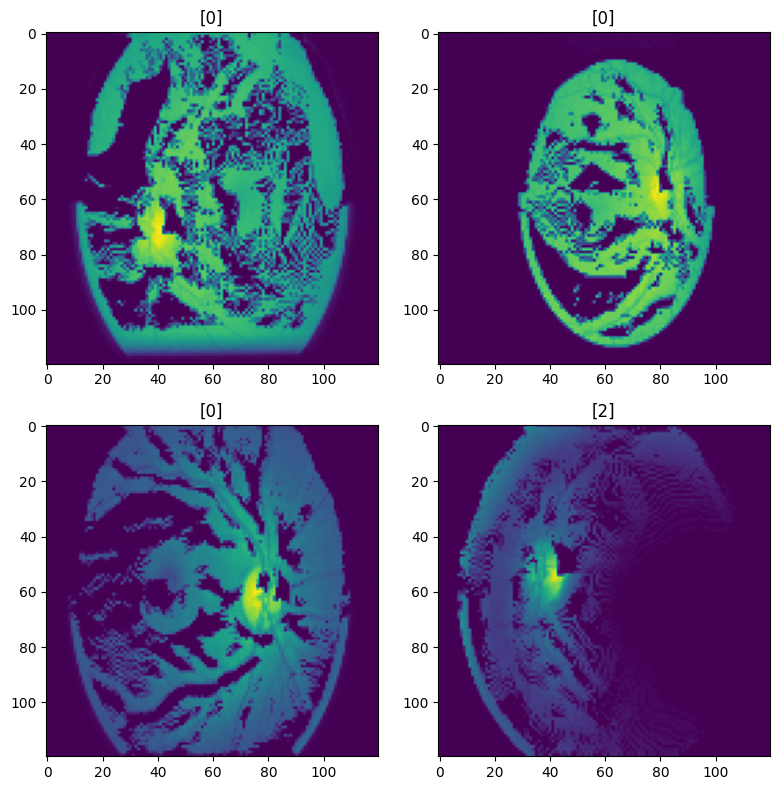

In [5]:
plt.figure(figsize=(8,8))
for i,img_path in enumerate(np.random.choice(image_names,4,replace=False),1):
  image=cv2.resize(cv2.imread(img_path),(224,224))
  image=cv2.resize(preprocess_image(image),(120,120))

  plt.subplot(2,2,i)
  plt.imshow(image)
  plt.title(labels[labels["image"]==img_path.split("/")[-1].split(".")[0]].level.values)
plt.tight_layout()
plt.show()

In [6]:
x=[f"{root}/{file}" for root,dir,files in os.walk("datasets") for file in files]
for i in x:
    dst=f"train/{i.split('/')[-1]}"
    os.replace(i,dst)

In [7]:
os.makedirs(f"curated_dataset/normal",exist_ok=True)
os.makedirs(f"curated_dataset/infected",exist_ok=True)
for severity in range(5):
  image_names=labels[labels["level"]==severity].image.values[:2000 if severity==0 else 500]
  for img_name in tqdm(image_names,desc=f"working for {severity}"):
    dest_dir=f"curated_dataset/normal/{img_name}.jpg" if severity ==0 else f"curated_dataset/infected/{img_name}.jpg"
    src_dir=f"train/{img_name}.jpeg"
    cv2.imwrite(dest_dir,cv2.resize(preprocess_image(cv2.imread(src_dir)),(120,120)))

working for 4: 100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


# Loading dataset

In [8]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.keras.mixed_precision.set_global_policy('mixed_float16')


2023-09-03 22:17:29.285627: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-03 22:17:29.471728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 22:17:30.384244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2023-09-03 22:17:32.143197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-09-03 22:17:32.143324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ravindra-pandey-HP-Pavilion-Gaming-Laptop-15-dk2xxx
2023-09-03 22:17:32.143331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ravindra-pandey-HP-Pavilion-Gaming-Laptop-15-dk2xxx
2023-09-03 22:17:32.143461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-09-03 22:17:32.143486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.10
2023-09-03 22:17:32.143491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.86.10 does not match DSO

In [17]:
def load_one_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)
    return image,label

In [18]:
image_names=[f"{root}/{fl}" for root,dirs,files in os.walk("curated_dataset") for fl in files]
np.random.shuffle(image_names)
labels = [0 if i.split("/")[1]== "normal" else 1  for i in image_names]

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_names,labels,random_state=5,test_size=0.2)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).map(load_one_image,num_parallel_calls=AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((X_test,y_test)).map(load_one_image,num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size=16).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=16).prefetch(AUTOTUNE)



# Model Building

In [131]:
import tensorflow as tf
from tensorflow.keras import layers

input_shape = (120, 120, 1)
num_classes = 2

def build_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)
    
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    upconv1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(pool2)
    upconv1_resized = tf.keras.layers.UpSampling2D(size=(2, 2))(upconv1)
    concat1 = tf.keras.layers.concatenate([conv1, upconv1_resized], axis=-1)

    output1= tf.keras.layers.Conv2D(2, (1, 1), activation="softmax",name="output_1")(concat1)
    X = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(output1)
    X = layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(X)
    X = layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(200, activation="relu")(X)
    X = layers.Dropout(0.5)(X)
    X = layers.Dense(100, activation="relu")(X)
    output = layers.Dense(1, activation="sigmoid")(X)

    model = tf.keras.Model(inputs, output)
    return model

final_model = build_model(input_shape, num_classes)

final_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

final_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 1)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 120, 120, 64)         640       ['input_4[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 120, 120, 64)         36928     ['conv2d_12[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 60, 60, 64)           0         ['conv2d_13[0][0]']           
 g2D)                                                                                       

In [21]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Diabetic_Retinopathymodel_checkpoint.h5',
    save_best_only=True)
log_dir="Diabetic_Retinopathy/log"#+ str(int(time.time()))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
)
history=final_model.fit(train_dataset,validation_data=test_dataset,epochs=10,callbacks=[tensorboard_callback,checkpoint_callback])

Epoch 1/10


200/200 [==============================] - 1907s 10s/step - loss: 0.7048 - accuracy: 0.4991 - val_loss: 0.6929 - val_accuracy: 0.5075
Epoch 2/10


/home/ravindra-pandey/miniconda3/envs/data_science/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 1843s 9s/step - loss: 0.6936 - accuracy: 0.5028 - val_loss: 0.6928 - val_accuracy: 0.5038
Epoch 3/10
200/200 [==============================] - 1839s 9s/step - loss: 0.6929 - accuracy: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 4/10
200/200 [==============================] - 1843s 9s/step - loss: 0.6898 - accuracy: 0.5359 - val_loss: 0.6899 - val_accuracy: 0.5275
Epoch 5/10
200/200 [==============================] - 1836s 9s/step - loss: 0.6954 - accuracy: 0.5044 - val_loss: 0.6918 - val_accuracy: 0.5300
Epoch 6/10
200/200 [==============================] - 1834s 9s/step - loss: 0.6912 - accuracy: 0.5316 - val_loss: 0.6941 - val_accuracy: 0.5312
Epoch 7/10
200/200 [==============================] - 1833s 9s/step - loss: 0.6927 - accuracy: 0.5197 - val_loss: 0.6978 - val_accuracy: 0.5050
Epoch 8/10
200/200 [==============================] - 1832s 9s/step - loss: 0.6906 - accuracy: 0.5281 - val_loss: 0.6924 - val_accuracy: 0.5238
Epo

In [22]:
final_model.save("final_model.h5")

In [1]:
import cv2
import tensorflow as tf

2023-09-04 10:53:05.708072: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-04 10:53:05.918075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 10:53:06.948689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model=tf.keras.models.load_model("final_model.h5")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2023-09-04 10:53:11.804660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-09-04 10:53:11.804769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ravindra-pandey-HP-Pavilion-Gaming-Laptop-15-dk2xxx
2023-09-04 10:53:11.804783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ravindra-pandey-HP-Pavilion-Gaming-Laptop-15-dk2xxx
2023-09-04 10:53:11.804980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-09-04 10:53:11.805017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2023-09-04 10:53:11.805026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.104.5 does not match DSO

In [111]:
labels=pd.read_csv("trainLabels.csv")
image_path,level=labels.sample(1).values[0]
image=cv2.resize(preprocess_image(cv2.imread(f"train/{image_path}.jpeg")),(120,120))
print("actual :",end='')
print(0) if level==0 else print(1)
print("predicted :",end='')
print(1) if model.predict(np.array([image]),verbose=0)[0][0]>0.52 else print(0)

actual :0
predicted :1


# 2nd Model

In [113]:
os.makedirs(f"dataset/normal",exist_ok=True)
os.makedirs(f"dataset/infected",exist_ok=True)
for severity in range(5):
  image_names=labels[labels["level"]==severity].image.values[:1000 if severity==0 else 500]
  for img_name in tqdm(image_names,desc=f"working for {severity}"):
    dest_dir=f"dataset/normal/{img_name}.jpg" if severity ==0 else f"dataset/infected/{img_name}.jpg"
    src_dir=f"train/{img_name}.jpeg"
    cv2.imwrite(dest_dir,cv2.resize(cv2.imread(src_dir),(120,120)))

working for 4: 100%|██████████| 500/500 [00:39<00:00, 12.68it/s]


In [5]:
def load_one_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)
    return image,label

In [6]:
image_names=[f"{root}/{fl}" for root,dirs,files in os.walk("dataset") for fl in files]
np.random.shuffle(image_names)
labels = [0 if i.split("/")[1]== "normal" else 1  for i in image_names]

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_names,labels,random_state=5,test_size=0.2)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).map(load_one_image,num_parallel_calls=AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((X_test,y_test)).map(load_one_image,num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size=16).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=16).prefetch(AUTOTUNE)



In [12]:
import tensorflow as tf
from tensorflow.keras import layers

input_shape = (120, 120, 1)
num_classes = 2

def build_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)
    
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    
    upconv1 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(pool2)
    upconv1_resized = tf.keras.layers.UpSampling2D(size=(2, 2))(upconv1)
    concat1 = tf.keras.layers.concatenate([conv1, upconv1_resized], axis=-1,)

    output1= tf.keras.layers.Conv2D(2, (1, 1), activation="softmax",name="output_1")(concat1)
    X = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(output1)
    X = layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(X)
    X = layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(200, activation="relu")(X)
    X = layers.Dropout(0.5)(X)
    X = layers.Dense(100, activation="relu")(X)
    output = layers.Dense(1, activation="sigmoid")(X)

    model = tf.keras.Model(inputs, output)
    return model

model2 = build_model(input_shape, num_classes)

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 120, 120, 1)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 120, 120, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 120, 120, 128)        73856     ['conv2d_12[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 60, 60, 128)          0         ['conv2d_13[0][0]']           
 g2D)                                                                                       

In [21]:
test_model=tf.keras.models.Model(model2.input,model2.get_layer("output_1").output)

actual :1


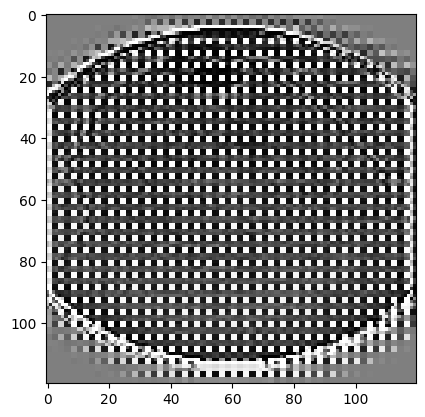

In [23]:
labels=pd.read_csv("trainLabels.csv")
image_path,level=labels.sample(1).values[0]
image=cv2.resize(cv2.imread(f"train/{image_path}.jpeg",0),(120,120))
print("actual :",end='')
print(0) if level==0 else print(1)
output=test_model.predict(np.array([image]),verbose=0)[0].T[1]
plt.imshow(output,"gray")

In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Diabetic_Retinopathymodel_checkpoint2.h5',
    save_best_only=True)
log_dir="Diabetic_Retinopathy/log2"#+ str(int(time.time()))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
)
history=model2.fit(train_dataset,validation_data=test_dataset,epochs=10,callbacks=[tensorboard_callback,checkpoint_callback])

Epoch 1/10
150/150 [==============================] - 140s 917ms/step - loss: 0.6570 - accuracy: 0.6621 - val_loss: 0.6439 - val_accuracy: 0.6733
Epoch 2/10


/home/ravindra-pandey/miniconda3/envs/data_science/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 137s 916ms/step - loss: 0.6431 - accuracy: 0.6650 - val_loss: 0.6343 - val_accuracy: 0.6733
Epoch 3/10
150/150 [==============================] - 143s 954ms/step - loss: 0.6397 - accuracy: 0.6650 - val_loss: 0.6357 - val_accuracy: 0.6733
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.6650